In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
my_font = FontProperties(fname=r"c:\windows\fonts\SimHei.ttf",size=12)

In [3]:
class WindDataSet(Dataset):
    def __init__(self,path,num_steps=50):
        self.data = []
        file = pd.read_csv(path,skiprows=1)
        self.wind = np.array(file['wind speed at 10m (m/s)']).reshape(1,-1)[0]
        wind_len = len(self.wind)
        for i in range(0,wind_len-num_steps-1):
            self.data.append((self.wind[i:i+num_steps],self.wind[i+num_steps+1]))
        self.data = self.data[:int(len(self.data)/50)*50]
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        seq,pre = self.data[index]
        return seq,pre


In [4]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
try_gpu()

device(type='cpu')

In [5]:
INPUT_SIZE=1
HIDDEN_SIZE=128
BATCH_SIZE=50
DROP_RATE=0.2

class lstm(nn.Module):
    def __init__(self):
        super(lstm,self).__init__()
        self.rnn = nn.LSTM(input_size=INPUT_SIZE,hidden_size=HIDDEN_SIZE)
        self.fc = nn.Linear(HIDDEN_SIZE,1)
    def forward(self,x,state):
        out,state = self.rnn(x.T.reshape((x.shape[1],-1,1)),state)
        out = self.fc(out)
        return out,state
    def begin_state(self,batch_size,device):
        return (torch.zeros((1,batch_size,HIDDEN_SIZE),device=device),torch.zeros((1,batch_size, HIDDEN_SIZE), device=device))

In [6]:
net = lstm()
lr = 0.001
device = try_gpu()
print(device)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
loss = nn.MSELoss()
epochs = 10
num_steps=50

cpu


In [7]:
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta/norm

In [8]:

def train_epoch(epoch,net,train_loader,device,train_loss):
    net.train()
    state=net.begin_state(batch_size=BATCH_SIZE, device=device)
    runing_loss=0
    for batch_idx,(X,y) in enumerate(train_loader):
        for s in state:
            s.detach_()
        optimizer.zero_grad()
        X,y = X.to(torch.float32).to(device),y.to(torch.float32).T.to(device)
        y_hat,state = net(X,state)
        y_hat = y_hat.reshape(num_steps,BATCH_SIZE)
        l = loss(y_hat,y)
        l.backward()
        grad_clipping(net, 1)
        optimizer.step()
        runing_loss += l.item()
        if batch_idx%100 == 99:
            print(f'epoch:{epoch+1},batch_idx:{batch_idx+1},running_loss:{runing_loss/100}')
            runing_loss = 0
        train_loss.append(l.item())


In [9]:
dataset = WindDataSet('./datasets/1.csv',num_steps)
print(dataset.__len__())

FileNotFoundError: [Errno 2] No such file or directory: './datasets/1.csv'

In [22]:
def save_net(path = 'wind.pt', net=None):
    torch.save(net.state_dict(),path)

In [10]:
def train(epochs):
    train_loss = []
    for epoch in range(epochs):
        for i in range(120):
            #print(f"file:{i+1}")
            dataset = WindDataSet(f'./datasets/{i}.csv',num_steps)
            train_loader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=0)
            train_epoch(epoch,net,train_loader,device,train_loss)
        print(f'###epoch:{epoch+1},train_loss:{train_loss[-1]}')
    save_net(net=net.to('cpu'))

In [24]:
train(epochs)

###epoch:1,train_loss:0.03661368787288666
###epoch:2,train_loss:0.02619202807545662
###epoch:3,train_loss:0.02340567484498024
###epoch:4,train_loss:0.022675903514027596
###epoch:5,train_loss:0.021947195753455162
###epoch:6,train_loss:0.02163986675441265
###epoch:7,train_loss:0.021297724917531013
###epoch:8,train_loss:0.020958367735147476
###epoch:9,train_loss:0.02057226188480854
###epoch:10,train_loss:0.01986120454967022


In [30]:
def load_net(path='newdata-epoch4.pt',net=None):
    net.load_state_dict(torch.load(path))
load_net(net=net)

In [31]:
def predict(prefix,num_preds,net,device):
    state = net.begin_state(batch_size=1,device=device)
    outputs = [prefix[0]]
    get_input = lambda:torch.tensor([outputs[-1]],device=device).reshape(1,1)
    for y in prefix[1:]:
        _,state = net(get_input(),state)
        outputs.append(y)
    for _ in range(num_preds):
        y,state = net(get_input(),state)
        outputs.append(y.reshape(1).detach()[0])
    tmp = []
    for t in outputs:
        tmp.append(t.item())
    outputs =tmp
    return outputs#torch.cat(outputs,dim=1)


In [32]:
test_dataset = WindDataSet('../data/wind_dataset144-2014/wind_dataset144//141.csv',num_steps=100)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)
preds,truth=None,None
for batch_idx,(X, y) in enumerate(test_loader):
    if batch_idx == 0:
        X = (X.reshape(-1).to(torch.float32))
        preds = predict(X,100,net.to(device),device)
    if batch_idx == 100:
        truth = np.array(X)
        break
truth = np.array(truth.reshape(-1))
print((preds[100:]))
print((truth))



[6.360733509063721, 6.293798446655273, 6.268898010253906, 6.292452335357666, 6.322640419006348, 6.3539886474609375, 6.401938438415527, 6.449078559875488, 6.491602897644043, 6.543828964233398, 6.5943779945373535, 6.638860702514648, 6.688019752502441, 6.734202861785889, 6.774083614349365, 6.816071510314941, 6.856260776519775, 6.8931708335876465, 6.933337688446045, 6.9753313064575195, 7.018627643585205, 7.067347049713135, 7.120454788208008, 7.177428722381592, 7.240427017211914, 7.308299541473389, 7.380463600158691, 7.458070278167725, 7.540164947509766, 7.626345634460449, 7.717333793640137, 7.812489986419678, 7.911602020263672, 8.015095710754395, 8.122461318969727, 8.233455657958984, 8.348158836364746, 8.466026306152344, 8.586719512939453, 8.710145950317383, 8.835875511169434, 8.963617324829102, 9.093149185180664, 9.223869323730469, 9.355047225952148, 9.48583984375, 9.615161895751953, 9.741999626159668, 9.865571975708008, 9.985332489013672, 10.101119041442871, 10.213118553161621, 10.321695

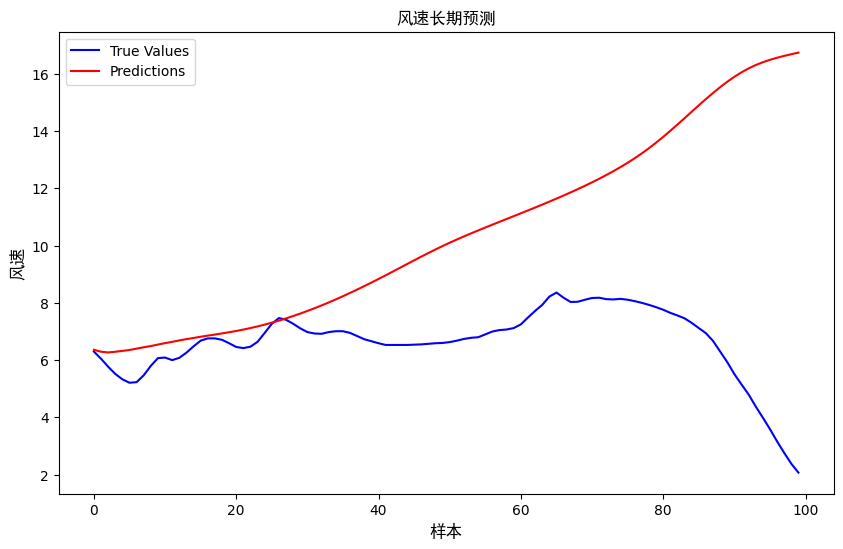

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(truth, label='True Values', color='blue')
plt.plot(preds[100:], label='Predictions', color='red')
plt.title('风速长期预测',fontproperties=my_font)
plt.xlabel('样本',fontproperties=my_font)
plt.ylabel('风速',fontproperties=my_font)
plt.legend()
plt.show()

In [34]:
test_dataset = WindDataSet('../data/wind_dataset144-2014/wind_dataset144/141.csv',num_steps=100)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)
preds,truthes=[],[]
for batch_idx,(X, y) in enumerate(test_loader):
        if batch_idx > 100:
                break
        X = (X.reshape(-1).to(torch.float32))
        pred = predict(X,1,net.to(device),device)
        truth = np.array(y).reshape(-1)[-1]
        preds.append(np.array(pred)[-1])
        truthes.append(truth)
print((preds[100:]))
print((truth))



[1.8549984693527222]
1.92


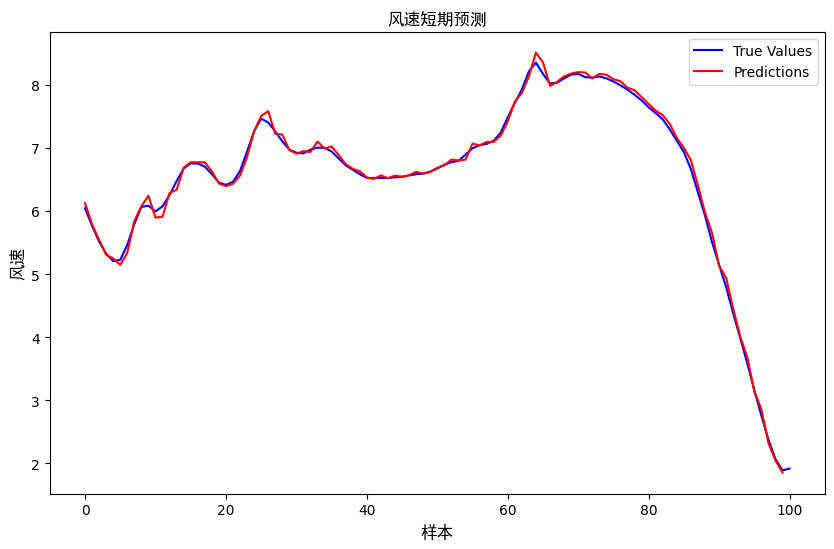

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(truthes, label='True Values', color='blue')
plt.plot(preds[1:], label='Predictions', color='red')
plt.title('风速短期预测',fontproperties=my_font)
plt.xlabel('样本',fontproperties=my_font)
plt.ylabel('风速',fontproperties=my_font)
plt.legend()
plt.show()